* 导入库函数和相关文件

In [2]:
import os 
import sys
sys.path.append('..')
import numpy as np
import torch
from einops import rearrange
from functools import partial
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from models.multimae.input_adapters import PatchedInputAdapter
from models.multimae.output_adapters import SpatialOutputAdapter
from models.multimae.multimae import pretrain_multimae_base

from PIL import Image

* 定义相关工具函数

In [3]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title='',normalize=True):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    if normalize:
        image = image * imagenet_std + imagenet_mean
    plt.imshow(torch.clip(image * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def show_images_side_by_side(img1, img2, normalize1=True, normalize2=True, title1='Image 1', title2='Image 2', figsize=(10,5)):
    # 创建1行2列的子图布局
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    if normalize1:
        img1 = img1 * imagenet_std + imagenet_mean
    if normalize2:
        img2 = img2 * imagenet_std + imagenet_mean

    img1 = torch.clip(img1 * 255, 0, 255).int()
    img2 = torch.clip(img2 * 255, 0, 255).int()
    
    # 显示第一张图
    ax1.imshow(img1)
    ax1.set_title(title1)
    ax1.axis('off')
    
    # 显示第二张图
    ax2.imshow(img2)
    ax2.set_title(title2)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    return
def denormalize(image):
    return image * imagenet_std + imagenet_mean

# def get_masked_image(img, mask, image_size=224, patch_size=16, mask_value=0.0):
#     img_token = rearrange(
#         img.detach().cpu(), 
#         'b c (nh ph) (nw pw) -> b (nh nw) (c ph pw)', 
#         ph=patch_size, pw=patch_size, nh=image_size//patch_size, nw=image_size//patch_size
#     )
#     img_token[mask.detach().cpu()!=0] = mask_value
#     img = rearrange(
#         img_token, 
#         'b (nh nw) (c ph pw) -> b c (nh ph) (nw pw)', 
#         ph=patch_size, pw=patch_size, nh=image_size//patch_size, nw=image_size//patch_size
#     )
#     return img
# def plot_predictions(input_dict, preds, masks, image_size=224):

#     masked_rgb = get_masked_image(
#         denormalize(input_dict['rgb']), 
#         masks['rgb'],
#         image_size=image_size,
#         mask_value=1.0
#     )[0].permute(1,2,0).detach().cpu()
#     masked_depth = get_masked_image(
#         input_dict['depth'], 
#         masks['depth'],
#         image_size=image_size,
#         mask_value=np.nan
#     )[0,0].detach().cpu()

#     pred_rgb = denormalize(preds['rgb'])[0].permute(1,2,0).clamp(0,1)
    

#     fig = plt.figure(figsize=(10, 10))
#     grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0)

#     grid[0].imshow(masked_rgb)
#     grid[1].imshow(pred_rgb2)
#     grid[2].imshow(denormalize(input_dict['rgb'])[0].permute(1,2,0).detach().cpu())

#     grid[3].imshow(masked_depth)
#     grid[4].imshow(pred_depth2)
#     grid[5].imshow(input_dict['depth'][0,0].detach().cpu())

#     plot_semseg_gt_masked(input_dict, masks['semseg'], grid[6], mask_value=1.0, image_size=image_size)
#     plot_semseg_pred_masked(input_dict['rgb'], preds['semseg'], input_dict['semseg'], masks['semseg'], grid[7], image_size=image_size)
#     plot_semseg_gt(input_dict, grid[8], image_size=image_size)

#     for ax in grid:
#         ax.set_xticks([])
#         ax.set_yticks([])
                
#     fontsize = 16
#     grid[0].set_title('Masked inputs', fontsize=fontsize)
#     grid[1].set_title('MultiMAE predictions', fontsize=fontsize)
#     grid[2].set_title('Original Reference', fontsize=fontsize)
#     grid[0].set_ylabel('RGB', fontsize=fontsize)
#     grid[3].set_ylabel('Depth', fontsize=fontsize)
#     grid[6].set_ylabel('Semantic', fontsize=fontsize)

#     return {
#         'rgb_input': masked_rgb,
#         'rgb_pred': pred_rgb2,
#         'rgb_gt': denormalize(input_dict['rgb'])[0].permute(1,2,0).detach().cpu(),
#         'depth_input': masked_depth,
#         'depth_pred': pred_depth2,
#         'depth_gt': input_dict['depth'][0,0].detach().cpu(),
#         'semseg_input': plot_semseg_gt_masked(input_dict, masks['semseg'], mask_value=1.0),
#         'semseg_pred': plot_semseg_pred_masked(input_dict['rgb'], preds['semseg'], input_dict['semseg'], masks['semseg']),
#         'semseg_gt': plot_semseg_gt(input_dict)
#     }

def plot_four_images(img1, img2, img3, img4, 
                    title1='Image 1', title2='Image 2', 
                    title3='Image 3', title4='Image 4', 
                    figsize=(10,10)):
    
    # 创建2x2布局
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    
    # 显示第一张图
    ax1.imshow(img1)
    ax1.set_title(title1)
    ax1.axis('off')
    
    # 显示第二张图
    ax2.imshow(img2)
    ax2.set_title(title2)
    ax2.axis('off')
    
    # 显示第三张图
    ax3.imshow(img3)
    ax3.set_title(title3)
    ax3.axis('off')
    
    # 显示第四张图
    ax4.imshow(img4)
    ax4.set_title(title4)
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()


def plot_predictions(input_dict, preds, masks, image_size=224):
    pred_rgb = preds['rgb'][0].permute(1,2,0).clamp(0,1)
    pred_touch = preds['touch'][0].permute(1,2,0).clamp(0,1)
    input_rgb = input_dict['rgb'][0].cpu().permute(1,2,0).clamp(0,1)
    input_touch = input_dict['touch'][0].cpu().permute(1,2,0).clamp(0,1)

    pred_rgb = torch.clip(denormalize(pred_rgb) * 255, 0, 255).int()
    pred_touch = torch.clip(pred_touch * 255, 0, 255).int()
    
    input_rgb = torch.clip(denormalize(input_rgb) * 255, 0, 255).int()
    input_touch = torch.clip(input_touch * 255, 0, 255).int()

    plot_four_images(input_rgb, pred_rgb, input_touch, pred_touch)


def run_one_image(input_dict, model, alphas, num_encoder_tokens):
    # 将alphas转换为字典格式
    if isinstance(alphas, (int, float)):
        alphas = [alphas] * 2
    preds, masks =model.forward(
        input_dict,
        mask_inputs=True,
        num_encoded_tokens=num_encoder_tokens,
        alphas=alphas,
    )
    preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
    masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

    res = plot_predictions(input_dict, preds, masks)

* 定义模型参数和相关函数

In [4]:
DOMAIN_CONF = {
    'rgb': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=3, stride_level=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=3, stride_level=1),
    },
    'touch': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=3, stride_level=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=3, stride_level=1),
    },
}
DOMAINS = ['rgb', 'touch']

input_adapters = {
    domain: dinfo['input_adapter'](
        patch_size_full=16,
    )
    for domain, dinfo in DOMAIN_CONF.items()
}
output_adapters = {
    domain: dinfo['output_adapter'](
        patch_size_full=16,
        dim_tokens=256,
        use_task_queries=True,
        depth=2,
        context_tasks=DOMAINS,
        task=domain
    )
    for domain, dinfo in DOMAIN_CONF.items()
}

multimae = pretrain_multimae_base(
    input_adapters=input_adapters,
    output_adapters=output_adapters,
)

/home/sgh/data/Anaconda3/envs/VisionNet/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647348947/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


* 加载预训练模型

In [22]:
# 指定参数路径
checkpoint_path = '../weights/pretrained_multimae_base.pth'

# 加载参数
checkpoint_model = torch.load(checkpoint_path, map_location='cpu')

# 加载模型参数
msg = multimae.load_state_dict(checkpoint_model['model'], strict=False)
# print(msg)

# 将模型放到GPU上
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
multimae.to(device)

/tmp/ipykernel_70464/81646829.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model = torch.load(checkpoint_path, map_location='cpu')


MultiMAE(
  (input_adapters): ModuleDict(
    (rgb): PatchedInputAdapter(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (touch): PatchedInputAdapter(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
  )
  (output_adapters): ModuleDict(
    (rgb): SpatialOutputAdapter(
      (task_embeddings): ParameterDict(
          (rgb): Parameter containing: [torch.cuda.FloatTensor of size 1x1x256 (cuda:0)]
          (touch): Parameter containing: [torch.cuda.FloatTensor of size 1x1x256 (cuda:0)]
      )
      (decoder): CrossAttention(
        (q): Linear(in_features=256, out_features=256, bias=True)
        (kv): Linear(in_features=256, out_features=512, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (context_norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (query_norm): Layer

* 加载指定路径下的图片，并可视化

/tmp/ipykernel_73559/79757024.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image = image * imagenet_std + imagenet_mean


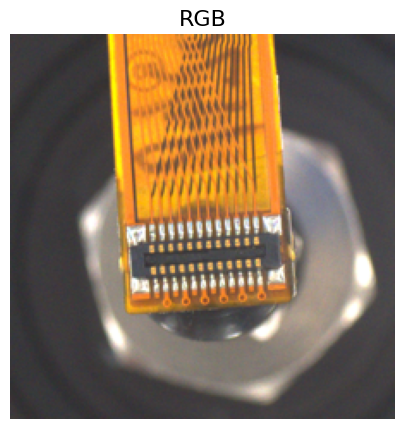

In [5]:
root_img_dir = '../dataset/multimae_eval'
rgb_dir = os.path.join(root_img_dir, 'rgb')
touch_dir = os.path.join(root_img_dir, 'touch')
img_num = 5
plug_serial = '4024P'
rgb_path = os.path.join(rgb_dir, f'image_{plug_serial}_{img_num}.png')
touch_path = os.path.join(touch_dir, f'gel_image_{plug_serial}_{img_num}.png')
rgb_img = Image.open(rgb_path).convert('RGB')
touch_img = Image.open(touch_path).convert('RGB')

rgb_img = rgb_img.resize((224, 224))
touch_img = touch_img.resize((224, 224))

rgb_img = np.array(rgb_img)/255.
assert rgb_img.shape == (224, 224, 3) 

rgb_img = rgb_img - imagenet_mean
rgb_img = rgb_img / imagenet_std


plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.Tensor(rgb_img), title='RGB', normalize=True)
# rgb_img = TF.normalize(TF.to_tensor(rgb_img),mean=imagenet_mean, std=imagenet_std).unsqueeze(0)
# rgb_img = torch.Tensor(rgb_img).permute(2,0,1).unsqueeze(0)
# touch_img = TF.to_tensor(touch_img).unsqueeze(0)

# # normalize by ImageNet mean and std
# rgb_img = rgb_img - imagenet_mean
# rgb_img = rgb_img / imagenet_std
# # print(img.shape)
# plt.rcParams['figure.figsize'] = [10, 5]
# show_images_side_by_side(torch.Tensor(rgb_img), torch.Tensor(touch_img),normalize2=False, title1='RGB', title2='Touch')

* 将数据传给模型，并进行推理，可视化推理结果

/tmp/ipykernel_70464/79757024.py:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return image * imagenet_std + imagenet_mean


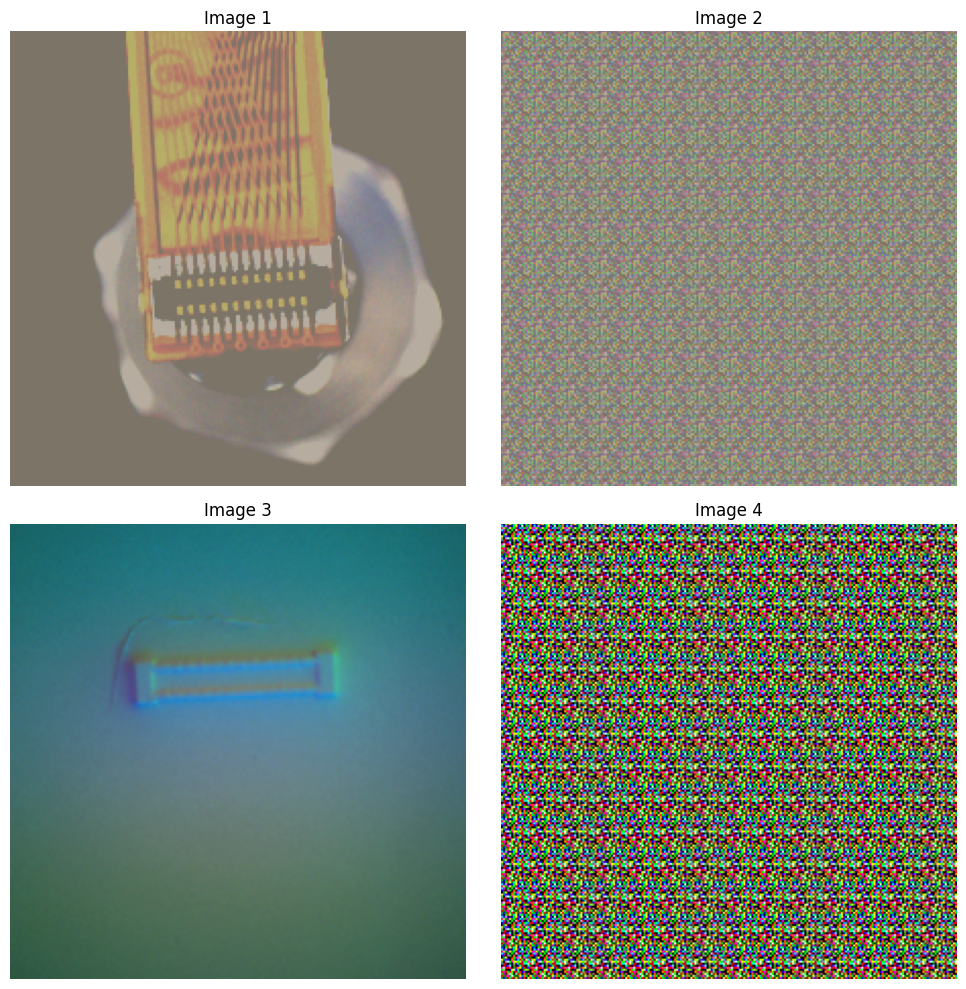

In [24]:
# input_dict = {
#     'rgb': torch.Tensor(rgb_img).permute(2,0,1).unsqueeze(0),  # (H,W,C) -> (1,C,H,W)
#     'touch': torch.Tensor(touch_img).permute(2,0,1).unsqueeze(0)  # 同上
# }
input_dict = {
    'rgb': rgb_img,
    'touch': touch_img,
}
input_dict = {k: v.to(device) for k, v in input_dict.items()}
run_one_image(input_dict, multimae, 1, 98)